In [1]:
"""
Plot cmap for ensembles
"""
# just store traces
# take in snapshot
# plot frame too
# make colors pretty
%load_ext autoreload
%autoreload 2
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import os

#import wx
from moviepy.editor import VideoFileClip

from deepgraphpose.utils_model import get_train_config

#if int(wx.__version__[0]) > 3:
#    wx.Thread_IsMain = wx.IsMainThread
os.environ["DLClight"] = "True"
# os.environ["Colab"] = "True"
from deeplabcut.utils import auxiliaryfunctions
from deepgraphpose.models.fitdgp_util import get_snapshot_path
import yaml
from deepgraphpose.models.eval import setup_dgp_eval_graph
from skimage.util import img_as_ubyte
from tqdm import tqdm

from matplotlib import animation

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


In [2]:
import argparse
import numpy as np
parser = argparse.ArgumentParser()

parser.add_argument(
    "--dlcpaths",
        nargs='+',
    default=[
    "/share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-01/",
    "/share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-02/",
    "/share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-03/",
    "/share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-04/",
    ],
)

parser.add_argument(
    "--snapshot",
    default="snapshot-step3-final--0",
    #nargs='+',
    #default=['snapshot-step0c-final--0',
    #         'snapshot-step2-final--0',
    #         ],)
)


parser.add_argument(
    "--snapshotnames",
    nargs='+',
    #default=[],
    default=['run0', 'run1','run2', 'run3'],
)

parser.add_argument('--moviefile',type=str,
                    default="/home/ekb2154/data/libraries/dgp_paninski/etc/ensembles/iblvideos/right_movie_diff.mp4"
                   )
parser.add_argument('--dir',type=str, default='videodebug/')

parser.add_argument('--n', type=int, default=1000)

parser.add_argument('--llth', type=float, default=0.9)

parser.add_argument('--batch_size', type=int, default=10)


input_params = parser.parse_known_args()[0]
print('input_params')
print(vars(input_params))
#dlcpath = str(input_params.dlcpath)
n_frames = np.int(input_params.n)
moviefile = str(input_params.moviefile)
shuffle= 1
snapshot = str(input_params.snapshot)
from pathlib import Path
from os.path import isfile, join
from os import listdir


input_params
{'dlcpaths': ['/share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-01/', '/share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-02/', '/share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-03/', '/share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-04/'], 'snapshot': 'snapshot-step3-final--0', 'snapshotnames': ['run0', 'run1', 'run2', 'run3'], 'moviefile': '/home/ekb2154/data/libraries/dgp_paninski/etc/ensembles/iblvideos/right_movie_diff.mp4', 'dir': 'videodebug/', 'n': 1000, 'llth': 0.9, 'batch_size': 10}


In [3]:
figname = Path(input_params.dir) / 'compare.png'
def get_body(dlcpath, n_frames):
    print('Collecting markers from snapshot')
    print(snapshot)
    print('\n')
    video_clip = VideoFileClip(str(moviefile))
    fps = video_clip.fps
    n_frames2 = min(n_frames + 1, np.ceil(video_clip.fps * video_clip.duration).astype('int'))
    offset= 0
    video_clip = video_clip.subclip(offset, offset+(n_frames2 / fps))

    snapshot_path, cfg_yaml = get_snapshot_path(snapshot, dlcpath, shuffle=shuffle)
    cfg = auxiliaryfunctions.read_config(cfg_yaml)

    # %%
    proj_cfg_file = str(cfg_yaml)
    dgp_model_file = str(snapshot_path)
    # %% estimate_pose
    # load dlc project config file
    print('loading dlc project config...')
    with open(proj_cfg_file, 'r') as stream:
        proj_config = yaml.safe_load(stream)
    proj_config['video_path'] = None
    dlc_cfg = get_train_config(proj_config, shuffle=shuffle)
    print('done')
    # %%
    try:
        dlc_cfg.net_type = 'resnet_50'
        sess, mu_n, softmax_tensor, scmap, locref, inputs = setup_dgp_eval_graph(dlc_cfg,
                                                                                 dgp_model_file)
    except:
        dlc_cfg.net_type = 'resnet_101'
        sess, mu_n, softmax_tensor, scmap, locref, inputs = setup_dgp_eval_graph(dlc_cfg,
                                                                                 dgp_model_file)
    # %%
    nj = dlc_cfg.num_joints
    bodyparts = cfg['bodyparts']
    # %%
    nx, ny = video_clip.size
    nx_out, ny_out = int((nx - dlc_cfg.stride/2)/dlc_cfg.stride  + 5), int((ny - dlc_cfg.stride/2)/dlc_cfg.stride  + 5)
    #%%
    markers = np.zeros((n_frames2 + 1, dlc_cfg.num_joints, 2))
    likes = np.zeros((n_frames2 + 1, dlc_cfg.num_joints))
    softmaxtensor = np.zeros((n_frames2 + 1, ny_out, nx_out, dlc_cfg.num_joints))
    pbar = tqdm(total=n_frames2, desc='processing video frames')
    for ii, frame in enumerate(video_clip.iter_frames()):
        ff = img_as_ubyte(frame)
        mu_n_batch, pred_np1 = sess.run( [mu_n,  scmap], feed_dict={inputs: ff[None, :, :, :]})
        nx_out_true, ny_out_true, _ = pred_np1[0].shape
        markers[ii] = mu_n_batch[0]
        num_frames = mu_n_batch.shape[0]  # nb #+ 1
        sigmoid_pred_np = np.exp(pred_np1) / (np.exp(pred_np1) + 1)        
        #softmaxtensor[ii][:nx_out_true,:ny_out_true] = sigmoid_pred_np[0]
        softmaxtensor[ii][:nx_out_true,:ny_out_true] = pred_np1[0]
        mu_likelihoods = np.zeros((num_frames, nj, 2)).astype('int')
        likelihoods = np.zeros((num_frames, nj))
        offset_mu_jj = 0
        for ff_idx in range(num_frames):
            for jj_idx in range(nj):
                # continuous so pick max in
                mu_jj = mu_n_batch[ff_idx, jj_idx]
                ends_floor = np.floor(mu_jj).astype('int') - offset_mu_jj
                ends_ceil = np.ceil(mu_jj).astype('int') + 1 + offset_mu_jj
                sigmoid_pred_np_jj = sigmoid_pred_np[ff_idx, :, :, jj_idx]
                spred_centered = sigmoid_pred_np_jj[ ends_floor[0]: ends_ceil[0],
                                 ends_floor[1]: ends_ceil[1]]
                mu_likelihoods[ff_idx, jj_idx] = np.unravel_index(
                    np.argmax(spred_centered), spred_centered.shape)
                mu_likelihoods[ff_idx, jj_idx] += [ends_floor[0], ends_floor[1]]
                likelihoods[ff_idx, jj_idx] = sigmoid_pred_np_jj[
                    int(mu_likelihoods[ff_idx, jj_idx][0]), int(mu_likelihoods[ff_idx, jj_idx][1])]
        likes[ii] = likelihoods[0]
        pbar.update(1)

    likes = likes[:ii+1]
    markers = markers[:ii+1]
    softmaxtensor = softmaxtensor[:ii+1,:nx_out_true,:ny_out_true,:]
    pbar.close()
    sess.close()
    video_clip.close()
    print('Finished collecting markers')
    print('\n')
    xx = markers[:, :, 1] * dlc_cfg.stride + 0.5 * dlc_cfg.stride
    yy = markers[:, :, 0] * dlc_cfg.stride + 0.5 * dlc_cfg.stride

    return xx, yy, likes, nj, bodyparts, softmaxtensor, dlc_cfg

print('Start')
xrs,yrs, masksll, softmaxtensors = [], [], [],[]
num_traces = len(input_params.dlcpaths)
for ss_idx, dlcpath in enumerate(input_params.dlcpaths):
    xr, yr, likes, nj, bodyparts, softmaxtensor, dlc_cfg = get_body(dlcpath, n_frames)
    maskll = likes > input_params.llth

    # here is where we should do the snapshots
    xrs.append(xr)
    yrs.append(yr)
    masksll.append(maskll)
    softmaxtensors.append(softmaxtensor)


Start
snapshot-step3-final--0


loading dlc project config...
/share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-01/dlc-models/iteration-0/iblfingersJan1-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


loading resnet model weights from /share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-01/dlc-models/iteration-0/iblfingersJan1-trainset100shuffle1/train/snapshot-step3-final--0...WARNING:tensorflow:From /home/ekb2154/.conda/envs/dgptest/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-01/dlc-models/iteration-0/iblfingersJan1-trainset100shuffle1/train/snapshot-step3-final--0


INFO:tensorflow:Restoring parameters from /share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-01/dlc-models/iteration-0/iblfingersJan1-trainset100shuffle1/train/snapshot-step3-final--0
processing video frames:   0%|          | 0/26 [00:00<?, ?it/s]

done


processing video frames: 100%|██████████| 26/26 [00:02<00:00, 11.83it/s]


Finished collecting markers


snapshot-step3-final--0


loading dlc project config...
/share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-02/dlc-models/iteration-0/iblfingersJan2-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-02/dlc-models/iteration-0/iblfingersJan2-trainset100shuffle1/train/snapshot-step3-final--0...INFO:tensorflow:Restoring parameters from /share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-02/dlc-models/iteration-0/iblfingersJan2-trainset100shuffle1/train/snapshot-step3-final--0


INFO:tensorflow:Restoring parameters from /share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-02/dlc-models/iteration-0/iblfingersJan2-trainset100shuffle1/train/snapshot-step3-final--0
processing video frames:   0%|          | 0/26 [00:00<?, ?it/s]

done


processing video frames: 100%|██████████| 26/26 [00:01<00:00, 25.79it/s]


Finished collecting markers


snapshot-step3-final--0


loading dlc project config...
/share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-03/dlc-models/iteration-0/iblfingersJan3-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-03/dlc-models/iteration-0/iblfingersJan3-trainset100shuffle1/train/snapshot-step3-final--0...INFO:tensorflow:Restoring parameters from /share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-03/dlc-models/iteration-0/iblfingersJan3-trainset100shuffle1/train/snapshot-step3-final--0


INFO:tensorflow:Restoring parameters from /share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-03/dlc-models/iteration-0/iblfingersJan3-trainset100shuffle1/train/snapshot-step3-final--0
processing video frames:   0%|          | 0/26 [00:00<?, ?it/s]

done


processing video frames: 100%|██████████| 26/26 [00:01<00:00, 25.90it/s]


Finished collecting markers


snapshot-step3-final--0


loading dlc project config...
/share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-04/dlc-models/iteration-0/iblfingersJan4-trainset100shuffle1/train/pose_cfg.yaml
done
Initializing ResNet
loading resnet model weights from /share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-04/dlc-models/iteration-0/iblfingersJan4-trainset100shuffle1/train/snapshot-step3-final--0...INFO:tensorflow:Restoring parameters from /share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-04/dlc-models/iteration-0/iblfingersJan4-trainset100shuffle1/train/snapshot-step3-final--0


INFO:tensorflow:Restoring parameters from /share/ctn/users/ekb2154/data/datasets/tracki/iblfingers/model_data/iblfingers-kelly-2030-01-04/dlc-models/iteration-0/iblfingersJan4-trainset100shuffle1/train/snapshot-step3-final--0
processing video frames:   0%|          | 0/26 [00:00<?, ?it/s]

done


processing video frames: 100%|██████████| 26/26 [00:01<00:00, 25.95it/s]


Finished collecting markers




In [4]:
#%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
#%%
print('Init video')
video_clip = VideoFileClip(moviefile)
fps = video_clip.fps
n_frames = min(n_frames + 1, np.ceil(video_clip.fps * video_clip.duration).astype('int'))
offset = 0
video_clip = video_clip.subclip(offset, offset + (n_frames / fps))
n_frames = xr.shape[0]

Init video


In [6]:
#ref_ = np.stack(softmaxtensors).mean(0)
ref_ = np.median(softmaxtensors,0)
ref_x = np.empty_like(xr)
ref_y = np.empty_like(yr)

In [7]:
for nt0 in range(n_frames):
    for njj0 in range(nj):
        ref_y[nt0,njj0], ref_x[nt0,njj0] = np.unravel_index(np.argmax(ref_[nt0,:,:,njj0]), ref_.shape[1:3])
ref_x = ref_x* dlc_cfg.stride + 0.5 * dlc_cfg.stride
ref_y = ref_y* dlc_cfg.stride + 0.5 * dlc_cfg.stride

In [14]:
color_markers = ['C{}'.format(ii) for ii in range(nj)]
markers = ['d','s','o','p','*','^','<','>','h']

nt0=0
hmaps = [[]]*num_traces*nj
hmapmeans =[[]]*nj
vimages = [[]]*(num_traces+1)
markerimages = [[]]*(num_traces+1)*nj
trace_name = ['run {}'.format(ii) for ii in range(1, num_traces + 1)]
trace_name.append('median')
frame = video_clip.get_frame(nt0 *1.0/fps)

fig, ax = plt.subplots(num_traces+1, nj+1, figsize=(20,10))
for njj0 in range(nj):
    ax[0,njj0+1].set_title(bodyparts[njj0], color=color_markers[njj0])

# traces
counter =0
for ii in range(num_traces):
    ax[ii,0].set_ylabel(trace_name[ii])
    for njj0 in range(nj):
        hmaps[counter] = ax[ii, njj0+1].imshow(softmaxtensors[ii][nt0,:,:,njj0])
        ax[ii, njj0+1].set_xticks([])
        ax[ii, njj0+1].set_yticks([])
        counter+=1
        
# imshow mean
counter1=0
ax[-1,0].set_ylabel(trace_name[-1])
for njj0 in range(nj):
    hmapmeans[counter1] = ax[-1, njj0+1].imshow(ref_[nt0,:,:,njj0])
    ax[-1, njj0+1].set_xticks([])
    ax[-1, njj0+1].set_yticks([])
    counter1+=1

# Frame
frame_name_ = 'Frame {}'.format(nt0)
frame_name = ax[0, 0].set_title(frame_name_)

counter2 = 0
for ii in range(num_traces+1):
    vimages[counter2] = ax[ii, 0].imshow(frame)
    ax[ii, 0].set_xticks([])
    ax[ii, 0].set_yticks([])
    counter2+=1

# Now add markers
counter3=0
for ii in range(num_traces):
    for njj0 in range(nj):
        mimage_, = ax[ii,0].plot(xrs[ii][nt0,njj0],yrs[ii][nt0,njj0],marker=markers[njj0],c=color_markers[njj0])
        ax[ii, 0].set_xticks([])
        ax[ii, 0].set_yticks([])
        markerimages[counter3] = mimage_
        counter3 +=1

for njj0 in range(nj):
    mimage_, = ax[-1, 0].plot(ref_x[nt0,njj0],ref_y[nt0,njj0],marker=markers[njj0], c=color_markers[njj0])
    markerimages[counter3] = mimage_
    counter3+=1

allmyplots = hmaps+ hmapmeans +vimages + markerimages

plt.tight_layout()
#plt.show()

In [17]:
def init():
    return allmyplots

def animate3(nt0):

    frame = video_clip.get_frame(nt0 *1.0/ fps)
    # traces
    counter = 0
    for ii in range(num_traces):
        for njj0 in range(nj):
            hmaps[counter].set_array(softmaxtensors[ii][nt0,:,:,njj0])
            counter+=1
    
    # imshow mean    
    counter = 0
    for njj0 in range(nj):
        hmapmeans[counter].set_array(ref_[nt0,:,:,njj0])
        counter+=1
    
    # Frame
    frame_name_ = 'Frame {}'.format(nt0)
    frame_name.set_text(frame_name_)
    
    counter = 0
    for ii in range(num_traces+1):
        vimages[counter].set_array(frame)
        counter +=1

    # Now add markers
    counter = 0
    for ii in range(num_traces):
        for njj0 in range(nj):
            markerimages[counter].set_data(xrs[ii][nt0,njj0], yrs[ii][nt0,njj0])
            counter +=1

    for njj0 in range(nj):
        markerimages[counter].set_data(ref_x[nt0,njj0], ref_y[nt0,njj0])
        counter +=1
    
    return allmyplots
from matplotlib import animation, rc
from IPython.display import HTML
import time

anim = animation.FuncAnimation(fig, animate3, #init_func=init,
                               frames=n_frames, interval=20, blit=True)

In [18]:
figname = Path(moviefile).parent / (Path(moviefile).stem + '_cmap.mp4')
print(figname)
start = time.time()
anim.save(str(figname))
print('time ' + str(np.round(time.time() - start,2)) + ' sec')
print(figname)

/home/ekb2154/data/libraries/dgp_paninski/etc/ensembles/iblvideos/right_movie_diff_cmap.mp4
time 20.99 sec
/home/ekb2154/data/libraries/dgp_paninski/etc/ensembles/iblvideos/right_movie_diff_cmap.mp4


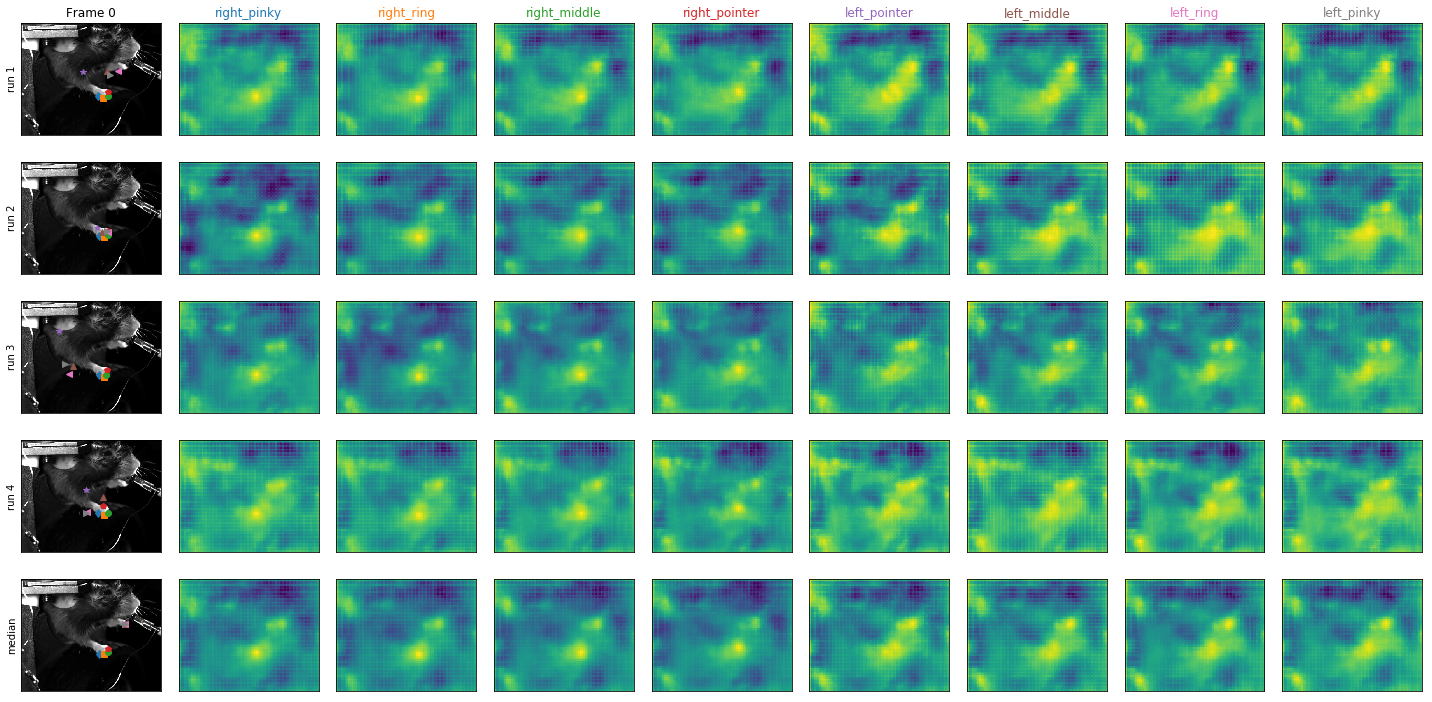

In [16]:
fig

In [ ]:
min_coord = np.vstack(xrs).min(0)
max_coord = np.vstack(xrs).max(0)
print(min_coord, max_coord)

In [ ]:
scale_trace=100
# closes multiple of 100
min_ycoord = (min_coord//scale_trace - 1)*scale_trace
max_ycoord = (max_coord//scale_trace + 1)*scale_trace
off_coord = max_ycoord - min_ycoord
print(min_ycoord, max_ycoord,off_coord)
offset = np.ones(nj)*10
ytracelabels = [np.linspace(min_ycoord[x], max_ycoord[x],3) for x in range(nj)]
print(ytracelabels)

In [ ]:
dlc_ssx = 0
dgp_ssx = 1
xr_dlc_train = xrs[dlc_ssx].T
yr_dlc_train = yrs[dlc_ssx].T
xr = xrs[dgp_ssx].T
yr = yrs[dgp_ssx].T
xcmap_dlc = softmaxtensors[dlc_ssx]
xcmap_dgp = softmaxtensors[dgp_ssx]


dlc_vmin = xcmap_dlc.min()
dlc_vmax = xcmap_dlc.max()

dgp_vmin = xcmap_dgp.min()
dgp_vmax = xcmap_dgp.max()

num_frames = n_frames

In [ ]:
tidx = 0
#frame_name = resnet_idx_chunk[tidx]
frame_name = tidx#str(tidx)
print(frame_name)
frame = video_clip.get_frame(frame_name *1.0/ fps)
dxs_dlc = xr_dlc_train[:,tidx]
dys_dlc = yr_dlc_train[:,tidx]
dxs_dgp = xr[:, tidx]
dys_dgp = yr[:, tidx]
xmap_dlc = xcmap_dlc[tidx,:,:,:]
xmap_dgp = xcmap_dgp[tidx,:,:,:]
cmap = 'jet'
print(frame_name)

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({#'font.sans-serif' : 'Helveltica', #'sans-serif',#'Helvetica',
                     'axes.labelsize': 9,
                     'xtick.labelsize' : 9,
                     'ytick.labelsize' : 9,
                     'axes.titlesize' : 11})
markersize = 6
#'<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
colors = ['r', 'royalblue','green','yellow']

In [ ]:
fig2 = plt.figure(constrained_layout=False, figsize=(11,8))
widths = [4, 1, 10]
heights = np.ones(2*nj)
spec2 = fig2.add_gridspec(ncols=3, nrows=2*nj, width_ratios=widths,
                          height_ratios=heights)
#spec2.update(wspace=0.025, hspace=0.05) 
spec2.update(hspace=0.5) 


# DGP
f2_ax1 = fig2.add_subplot(spec2[:nj, 0])
frame_title = f2_ax1.set_title('Frame {} \n DGP'.format(frame_name))

dgp_img = f2_ax1.imshow(frame)
f2_ax1.set_aspect(aspect='auto',anchor='C')
f2_ax1.set_xticklabels([])

dgp_frames = []
for part_idx in range(nj):
    dgp_frame, = f2_ax1.plot(
        dxs_dgp[part_idx],
        dys_dgp[part_idx],
        c=colors[0],#colors[part_idx],
        marker=markers[part_idx],
        ms=markersize,
        markeredgecolor='white',
        markeredgewidth=0.5,
    )
    dgp_frames.append(dgp_frame)

# DLC
f2_ax2 = fig2.add_subplot(spec2[nj:, 0])
#f2_ax2.set_title('DLC \n Frame {}'.format(frame_name))
f2_ax2.set_title('DLC')
dlc_img = f2_ax2.imshow(frame)
f2_ax2.set_aspect(aspect='auto',anchor='C')

dlc_frames = []
for part_idx in range(nj):
    dlc_frame, = f2_ax2.plot(
        dxs_dlc[part_idx],
        dys_dlc[part_idx],
        c=colors[1],
        marker=markers[part_idx],
        ms=markersize,
        markeredgecolor='white',
        markeredgewidth=0.5,

    )
    dlc_frames.append(dlc_frame)

# add row of confidence maps for DGP

dgp_cmaps= []
for njj in range(nj):
    f2_ax2 = fig2.add_subplot(spec2[2*njj, 1])
    #f2_ax2.set_ylabel('idx {}'.format(njj+1))

    f2_ax2.set_title("DGP", pad=3)# \n target {}".format(njj))
    f2_ax2.set_xticks([])
    f2_ax2.set_yticks([])
    dgp_cmap = f2_ax2.imshow(xmap_dgp[:,:,njj], cmap=cmap, vmin=dgp_vmin, vmax=dgp_vmax)#, vmin=vmin, vmax=vmax)
    #if njj == (nj -1):
    #    colorbar(dgp_cmap, cbar_ticks_number=2)
    
    f2_ax2.set_aspect(aspect='auto',anchor='C')
    dgp_cmaps.append(dgp_cmap)
#vmin = xmap_dlc.min()
#vmax = xmap_dlc.max()
dlc_cmaps =[]
for njj in range(nj):
    f2_ax2 = fig2.add_subplot(spec2[2*njj+1, 1])
    #if njj == 0:
    f2_ax2.set_title("DLC",pad=3)#\n target {}".format(njj))
    #else:
    #    f2_ax2.set_title("target {}".format(njj))
    f2_ax2.set_xticks([])
    f2_ax2.set_yticks([]) 
    dlc_cmap = f2_ax2.imshow(xmap_dlc[:,:,njj], cmap=cmap, vmin=dlc_vmin, vmax=dlc_vmax)#, vmin=vmin, vmax=vmax)
    #if njj == (nj -1):
    #    colorbar(dlc_cmap, cbar_ticks_number=2)
    dlc_cmaps.append(dlc_cmap)
    f2_ax2.set_aspect(aspect='auto',anchor='C')

dgp_mtxs = []
dlc_mtxs = []
# x traces
for njj in range(nj):
    f2_ax2 = fig2.add_subplot(spec2[2*njj:2*njj+2, 2:])
    f2_ax2.set_title(bodyparts2[njj])
    f2_ax2.plot(xr_dlc_train[njj,:],c=colors[1], linewidth=1.5, linestyle='-')
    f2_ax2.plot(xr[njj,:], c=colors[0], linewidth=1.5, linestyle='-')
    f2_ax2.set_ylabel('x', labelpad=0)

    f2_ax2.set_xlim([ -0.09, num_frames -0.99])
    dgp_mtx, = f2_ax2.plot(tidx, dxs_dgp[njj], c=colors[0], marker=markers[njj], markersize=5,markerfacecolor=None)
    dlc_mtx, = f2_ax2.plot(tidx, dxs_dlc[njj], c=colors[1], marker=markers[njj], markersize=5,markerfacecolor=None)

    dgp_mtxs.append(dgp_mtx)
    dlc_mtxs.append(dlc_mtx)
    
    if (njj +1 < nj):
        f2_ax2.set_xticks([])
    
    f2_ax2.spines["top"].set_visible(False)
    f2_ax2.spines["right"].set_visible(False)
    f2_ax2.tick_params(direction='in',)

plt.tight_layout()
#plt.show()

In [ ]:
print(figname)
plt.savefig(figname, bbox_inches='tight')

plt.close()
print(figname)
"""
start = time.time()
HTML(anim.to_html5_video())
print(time.time() - start)
"""




In [ ]:
#moviedirout ='videodebug/'
#movie_name =moviedirout + 'ctp__{}__{}__{}.mp4'.format(dlcpath.rsplit('/',1)[-1],
#                                                     video_file.rsplit(
#    '/')[-1].rsplit('.',1)[0],'--'.join(input_params.snapshotnames)

#)
#print(movie_name)

In [ ]:
figname

In [ ]:
make_vid = False

if make_vid:
    def animate(tidx):
    frame = video_clip.get_frame(tidx *1.0/ fps)
    dxs_dlc = xr_dlc_train[:,tidx]
    dys_dlc = yr_dlc_train[:,tidx]
    dxs_dgp = xr[:,tidx]
    dys_dgp = yr[:, tidx]
    frame_name = tidx#resnet_idx_chunk[tidx]
    xmap_dlc = xcmap_dlc[tidx,:,:,:]
    xmap_dgp = xcmap_dgp[tidx,:,:,:]

    frame_title.set_text("Frame {}".format(tidx))
    
    dgp_img.set_array(frame)
    dlc_img.set_array(frame)
    for njj in range(nj):
        dlc_frames[njj].set_data(dxs_dlc[njj], dys_dlc[njj])
        dgp_frames[njj].set_data(dxs_dgp[njj], dys_dgp[njj])

        dlc_cmaps[njj].set_data(xmap_dlc[:,:,njj])
        dgp_cmaps[njj].set_data(xmap_dgp[:,:,njj])

        #dgp_mtys[njj].set_data(tidx, dys_dgp[njj])
        dgp_mtxs[njj].set_data(tidx, dxs_dgp[njj])
        
        #dlc_mtys[njj].set_data(tidx, dys_dlc[njj])
        dlc_mtxs[njj].set_data(tidx, dxs_dlc[njj])

        #outputs = [frame_title, dgp_img , dlc_img], dlc_frames, dgp_frames, dlc_cmaps, dgp_cmaps, dgp_mtys, dgp_mtxs, dlc_mtys,dlc_mtxs
        outputs = [frame_title, dgp_img , dlc_img], dlc_frames, dgp_frames, dlc_cmaps, dgp_cmaps, dgp_mtxs,dlc_mtxs
    return  [item for sublist in outputs for item in sublist]


    from matplotlib import animation, rc
    from IPython.display import HTML
    import time

    time.time()


    anim = animation.FuncAnimation(fig2, animate,# init_func=init,
                                   frames=num_frames, interval=20, blit=True)



    print(figname)
    start = time.time()
    anim.save(str(figname))
    print('time ' + str(np.round(time.time() - start,2)) + ' sec')
    print(figname)

In [ ]:
plt.close()
video_clip.close()

In [ ]:
"""
#%%

# trial 1
# %%
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# mpl.use('module://backend_interagg')
mpl.rcParams.update({  'font.sans-serif' : 'Helveltica',
    'axes.labelsize': 3,
    'xtick.labelsize': 3,
    'ytick.labelsize': 3,
    'axes.titlesize': 3})

# plot the softmax tensor

#%%
from matplotlib.lines import Line2D
plt.style.use('default')

# only show 1 axes
fig2 = plt.figure(constrained_layout=False, figsize=(11, 6))
widths = [3, 1, 8]
heights = np.ones(2*nj)
num_cols = 3
num_rows = 2*nj
spec2 = fig2.add_gridspec(ncols=num_cols, nrows=num_rows, width_ratios=widths,
                          height_ratios=heights)

framerows = num_rows // num_traces
#%% DGP
markersize = 5
markersize2 = 5

color_class = plt.cm.ScalarMappable(cmap="cool")
colors = color_class.to_rgba(np.linspace(0, 1, nj ))
#markers = Line2D.filled_markers[::2]#[:nj + 1]
markers = ['o','s','*','d','^']
#%%
frame_0name = 0
frame = video_clip.get_frame(0)
tidx = 0
colors_traces= ['Cornflowerblue','r','g','y','o']
linestyles = ['--','-.',':','-']
#%%

imagesfig = [[]]*num_traces
imagesmakers = [[]]*num_traces
xtracesmarkers = [[]]*num_traces
#ytracesmarkers = [[]]*num_traces
frametitles = [[]]*num_traces
colormaps = [[]]*num_traces

for ss_idx in range(num_traces):
    f2_ax1 = fig2.add_subplot(spec2[ss_idx*framerows:ss_idx*framerows+ framerows, 0])
    if ss_idx == 0:
        frametitles[ss_idx] = f2_ax1.set_title('Frame {} \n {} '.format(frame_0name, input_params.snapshotnames[ss_idx]),
                                               color=colors_traces[ss_idx], weight='bold')
    else:
        frametitles[ss_idx] = f2_ax1.set_title('{}'.format(input_params.snapshotnames[ss_idx]),
                                               color=colors_traces[ss_idx], weight='bold')
    imagesfig[ss_idx] = f2_ax1.imshow(frame)#, aspect='auto')

    dgp_frames =[]
    for njj in range(nj):
        dxs_dgp = xrs[ss_idx][tidx]
        dys_dgp = yrs[ss_idx][tidx]
        dgp_frame, = f2_ax1.plot(dxs_dgp[njj], dys_dgp[njj], c=colors_traces[ss_idx],
            marker=markers[njj], ms=markersize, )
        dgp_frames.append(dgp_frame)

    imagesmakers[ss_idx] = dgp_frames

    xrs_tmp = xrs[ss_idx].copy()
    xrs_tmp[~masksll[ss_idx]] = np.nan
    # y traces
    yrs_tmp = yrs[ss_idx].copy()
    yrs_tmp[~masksll[ss_idx]] = np.nan

    # x traces
    dgp_mtxs = []
    for njj in range(nj):
        f2_ax2 = fig2.add_subplot(spec2[2*njj:2*njj+2, 2:])
        #f2_ax2.set_yticks([])
        # plot trace
        dgp_mtx, = f2_ax2.plot(tidx, dxs_dgp[njj], c=colors_traces[ss_idx],
                               marker=markers[njj], markersize=markersize2,
                               markerfacecolor=None, alpha=1.0)
        f2_ax2.plot(xrs[ss_idx][:, njj], c=colors_traces[ss_idx], linewidth=1.5,
                    linestyle='-', alpha=0.5)
        f2_ax2.plot(xrs_tmp[:, njj], c=colors_traces[ss_idx], linewidth=1.5,
                    linestyle=linestyles[ss_idx])
        dgp_mtxs.append(dgp_mtx)
        f2_ax2.set_ylabel('x coordinate')
        f2_ax2.set_xlim([0, n_frames - 1])
        #f2_ax2.set_ylim([0, n_frames - 1])
        f2_ax2.set_xticks(np.linspace(0,n_frames - 1,10))
        f2_ax2.set_title('{}'.format(bodyparts2[njj]))#, color=colors[njj],weight='bold')
        f2_ax2.set_ylim([ytracelabels[njj][0], ytracelabels[njj][-1]])
        # last axis
        if (ss_idx ==1)& (njj+1 ==nj):
            pass
        # all others
        else:
            f2_ax2.set_xticks([])

    xtracesmarkers[ss_idx] = dgp_mtxs
    
    # colorbars
    dgp_cmaps = []
    for njj in range(nj):
        print(2*njj + ss_idx)
        f2_ax2 = fig2.add_subplot(spec2[2*njj + ss_idx, 1])
        f2_ax2.set_yticks([])
        f2_ax2.set_xticks([])
        cmaps = f2_ax2.imshow(softmaxtensors[ss_idx][tidx,:, :, njj], 'viridis', vmin=0, vmax = 0.99, aspect='auto')
        f2_ax2.set_title('{}'.format(input_params.snapshotnames[ss_idx]),
                        fontsize=7, pad=2
                        )#weight='bold')
        
        dgp_cmaps.append(cmaps)
    colormaps[ss_idx] = dgp_cmaps
        
#%%
plt.tight_layout()
def animate(tidx):
    frame = video_clip.get_frame(tidx * 1.0 / fps)
    for ss_idx in range(num_traces):
        dxs_dlc = xrs[ss_idx][tidx,:]
        dys_dlc = yrs[ss_idx][tidx,:]
        if ss_idx == 0:
            frametitles[ss_idx].set_text("Frame {} \n {} ".format(tidx, input_params.snapshotnames[ss_idx]))
        imagesfig[ss_idx].set_array(frame)
        for njj in range(nj):
            imagesmakers[ss_idx][njj].set_data(dxs_dlc[njj], dys_dlc[njj])
            ytracesmarkers[ss_idx][njj].set_data(tidx, dys_dlc[njj])
            xtracesmarkers[ss_idx][njj].set_data(tidx, dxs_dlc[njj])

    imagesmakers2 = [item for sublist in imagesmakers for item in sublist]
    ytracesmarkers2 = [item for sublist in ytracesmarkers for item in sublist]
    xtracesmarkers2 = [item for sublist in xtracesmarkers for item in sublist]

    outputs = frametitles + imagesfig + imagesmakers2 + ytracesmarkers2 + xtracesmarkers2

    return outputs#[item for sublist in outputs for item in sublist]

print('NFRAMES +{}'.format(n_frames))
anim = animation.FuncAnimation(fig2, animate,  # init_func=init,
                               frames=n_frames, interval=20, blit=True)

#%%
import time
start = time.time()

anim.save(figname)

print(time.time() - start)
plt.close(fig2)
#%%
video_clip.close()

"""

In [ ]:
"""
import sys
#%%
dlc_movie = sys.argv[0]
dgp_movie = sys.argv[1]
fnameout = sys.argv[2]
#%%
#def create_movie_comparison(dgp_movie, dlc_movie, fnameout=‘dgp_dlc_compare.mp4’):
from moviepy.editor import TextClip
from moviepy.editor import CompositeVideoClip, VideoFileClip, clips_array
import numpy as np
# add concatenated video
from matplotlib import animation, rc
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
clip = VideoFileClip(video)
data0 = np.load(dlc_movie, allow_pickle=True)[()]
data1 = np.load(dgp_movie, allow_pickle=True)[()]
#outputmovie0 = VideoFileClip(str(dlc_movie))
x0 = data0[‘marker’].T # 2 x 4 x 999 #dlc
x1 = data1[‘marker’].T #dgp
#%%
nj = x0.shape[1]
nt = x0.shape[2]
#%%
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nj*2,1, sharex=True, figsize=(11,8))
comparison = [x0, x1] #dlc #dgp
label = [‘dlc’, ‘dgp’]
colors = [‘r’,‘b’]
linestyle = [‘-’,‘--’]
for cc, xm in enumerate(comparison):
  c = colors[cc]
  ls = linestyle[cc]
  for ii in range(nj):
    x = xm[0, ii]
    ax[ii].plot(x, c, linestyle=ls)
    ax[ii].set_xlim([0, nt])
  for ii in range(nj-1):
    ax[ii].set_xticks([])
  for ii in range(nj):
    ax[ii].set_ylabel(‘x_{}’.format(ii))
  for ii in range(nj):
    x = xm[1, ii]
    ax[ii+nj].plot(x, c, linestyle=ls)
    ax[ii+nj].set_xlim([0, nt])
  for ii in range(nj-1):
    ax[ii+nj].set_xticks([])
  for ii in range(nj):
    ax[ii+nj].set_ylabel(‘y_{}’.format(ii))
fig.suptitle(‘DLC red DGP blue’, y=0.999)
plt.tight_layout()
#plt.legend([‘dlc’, ‘dgp’])
plt.savefig(‘ibl3a.png’)
#plt.show()
plt.close()
exit()
#%%
# x0 = data0[‘marker’].T # 2 x 4 x 999 #dlc
dxs_dgp = x1[0,:,0]
dys_dgp = x1[1,:,0]
dxs_dlc = x0[0,:,0]
dys_dlc = x0[1,:,0]
#xr_dlc_train = x0[0,:,:]
# x0 = data0[‘marker’].T # 2 x 4 x 999 #dlc
xr_dlc_train = x0[0,:,:]
yr_dlc_train = x0[1,:,:]
xr = x1[0,:,:]
yr = x1[1,:,:]
#%%
fig2 = plt.figure(constrained_layout=False, figsize=(11, 8))
widths = [2, 1, 6]
heights = np.ones(2 * nj)
spec2 = fig2.add_gridspec(ncols=3, nrows=2 * nj, width_ratios=widths,
             height_ratios=heights)
#%% DGP
frame_0name = 0
num_frames = xr.shape[1]
#tidx = np.arange(num_frames)
frame = clip.get_frame(0)
tidx = 0
#%%
markersize = 2
colors = [‘r’, ‘deepskyblue’]
#mpl.rcParams.update({‘font.sans-serif’ : ‘Helveltica’, #‘sans-serif’,#‘Helvetica’,
#           ‘axes.labelsize’: 9,
#           ‘xtick.labelsize’ : 9,
#           ‘ytick.labelsize’ : 9,
#           ‘axes.titlesize’ : 11})
#%%
f2_ax1 = fig2.add_subplot(spec2[:nj, 0])
frame_title = f2_ax1.set_title(‘Frame {} \n DGP’.format(frame_0name))
dgp_img = f2_ax1.imshow(frame)
dgp_frames = []
for part_idx in range(nj):
  dgp_frame, = f2_ax1.plot(
    dxs_dgp[part_idx],
    dys_dgp[part_idx],
    c=colors[0], # colors[part_idx],
    marker=“d”,
    ms=markersize,
  )
  dgp_frames.append(dgp_frame)
# DLC
f2_ax2 = fig2.add_subplot(spec2[nj:, 0])
# f2_ax2.set_title(‘DLC \n Frame {}’.format(frame_name))
f2_ax2.set_title(‘DLC’)
dlc_img = f2_ax2.imshow(frame)
dlc_frames = []
for part_idx in range(nj):
  dlc_frame, = f2_ax2.plot(
    dxs_dlc[part_idx],
    dys_dlc[part_idx],
    c=colors[1],
    marker=“o”,
    ms=markersize,
  )
  dlc_frames.append(dlc_frame)
# %% x traces
dgp_mtxs = []
dlc_mtxs = []
# x traces
for njj in range(nj):
  f2_ax2 = fig2.add_subplot(spec2[2 * njj, 2:])
  f2_ax2.set_yticks([])
  f2_ax2.set_xticks([])
  f2_ax2.plot(xr_dlc_train[njj, :], c=colors[1], linewidth=1.5, linestyle=‘-’)
  f2_ax2.plot(xr[njj, :], c=colors[0], linewidth=1.5, linestyle=‘--’)
  f2_ax2.set_ylabel(‘x’)
  f2_ax2.set_xlim([0, num_frames])
  #f2_ax2.vlines(pv_all, ymin=0, ymax=600, linestyle=‘--’, linewidth=0.5)
  dgp_mtx, = f2_ax2.plot(tidx, dxs_dgp[njj], c=colors[0], marker=‘d’, markersize=5, markerfacecolor=None)
  dlc_mtx, = f2_ax2.plot(tidx, dxs_dlc[njj], c=colors[1], marker=‘o’, markersize=5, markerfacecolor=None)
  dgp_mtxs.append(dgp_mtx)
  dlc_mtxs.append(dlc_mtx)
  # if njj == 0:
  #  ax_txt = f2_ax2.set_title(“Frame {}“.format(t_idx))
#%% y traces
dgp_mtys = []
dlc_mtys = []
for njj in range(nj):
  f2_ax2 = fig2.add_subplot(spec2[2 * njj + 1, 2:])
  f2_ax2.set_yticks([])
  if njj < nj - 1:
    f2_ax2.set_xticks([])
  f2_ax2.plot(yr_dlc_train[njj, :], c=colors[1], linewidth=1.5, linestyle=‘-’)
  f2_ax2.plot(yr[njj, :], c=colors[0], linewidth=1.5, linestyle=‘--’)
  f2_ax2.set_ylabel(‘y’)
  f2_ax2.set_xlim([0, num_frames])
  #f2_ax2.vlines(pv_all, ymin=0, ymax=600, linestyle=‘--’, linewidth=0.5)
  dgp_mty, = f2_ax2.plot(tidx, dys_dgp[njj], c=colors[0], marker=‘d’, markersize=5, markerfacecolor=None)
  dlc_mty, = f2_ax2.plot(tidx, dys_dlc[njj], c=colors[1], marker=‘o’, markersize=5, markerfacecolor=None)
  dgp_mtys.append(dgp_mty)
  dlc_mtys.append(dlc_mty)
plt.tight_layout(h_pad=0, w_pad=0)
# In[ ]:
fps = clip.fps
def animate(tidx):
  #print(tidx)
  frame = clip.get_frame(tidx * 1.0 / fps)
  dxs_dlc = xr_dlc_train[:, tidx]
  dys_dlc = yr_dlc_train[:, tidx]
  dxs_dgp = xr[:, tidx]
  dys_dgp = yr[:, tidx]
  #frame_name = resnet_idx_chunk[tidx]
  #xmap_dlc = xcmap_dlc[tidx, :, :, :]
  #xmap_dgp = xcmap_dgp[tidx, :, :, :]
  frame_title.set_text(“Frame {} \n DGP “.format(tidx))
  dgp_img.set_array(frame)
  dlc_img.set_array(frame)
  for njj in range(nj):
    dlc_frames[njj].set_data(dxs_dlc[njj], dys_dlc[njj])
    dgp_frames[njj].set_data(dxs_dgp[njj], dys_dgp[njj])
    #dlc_cmaps[njj].set_data(xmap_dlc[:, :, njj])
    #dgp_cmaps[njj].set_data(xmap_dgp[:, :, njj])
    dgp_mtys[njj].set_data(tidx, dys_dgp[njj])
    dgp_mtxs[njj].set_data(tidx, dxs_dgp[njj])
    dlc_mtys[njj].set_data(tidx, dys_dlc[njj])
    dlc_mtxs[njj].set_data(tidx, dxs_dlc[njj])
    outputs = [frame_title, dgp_img, dlc_img], dlc_frames, dgp_frames, dgp_mtys, dgp_mtxs, dlc_mtys, dlc_mtxs
  return [item for sublist in outputs for item in sublist]
# In[ ]:
anim = animation.FuncAnimation(fig2, animate, # init_func=init,
                frames=num_frames, interval=20, blit=True)
#%%
#FFwriter=animation.FFMpegWriter(fps=20, metadata=dict(artist=‘Me’), bitrate=1800)#@, extra_args=[‘-vcodec’, ‘libx264’])
start = time.time()
anim.save(‘train_dgp.gif’)
#anim.save(‘ibl3a_2frames.mp4’, fps=fps, extra_args=[‘-vcodec’, ‘libx264’])
#anim.save(‘ibl3a.mp4’, writer=FFwriter)
print(time.time() - start)
clip.close()
#%%
import logging
logger = logging.getLogger(‘matplotlib’)
logger.setLevel(logging.INFO)
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# Check condition from matplotlib.animation source which if true will disable ffmpeg logging:
print(animation._log.getEffectiveLevel() > logging.DEBUG) # prints False
#%%
"""

In [ ]:
"""
import matplotlib.pyplot as plt
markersize = 2
markers = ['o','s','*','d','^']

colors = ['r', 'deepskyblue']
import matplotlib as mpl
mpl.rcParams.update({'font.sans-serif' : 'Helveltica', #'sans-serif',#'Helvetica',
                     'axes.labelsize': 9,
                     'xtick.labelsize' : 9,
                     'ytick.labelsize' : 9,
                     'axes.titlesize' : 11})


fig2 = plt.figure(constrained_layout=False, figsize=(11,8))
widths = [2,1,1, 6]
heights = np.ones(2*nj)
spec2 = fig2.add_gridspec(ncols=4, nrows=2*nj, width_ratios=widths,
                          height_ratios=heights)

# DGP
f2_ax1 = fig2.add_subplot(spec2[:nj, 0])
frame_title = f2_ax1.set_title('Frame {} \n DGP'.format(frame_name))

dgp_img = f2_ax1.imshow(frame)

dgp_frames = []
for part_idx in range(nj):
    dgp_frame, = f2_ax1.plot(
        dxs_dgp[part_idx],
        dys_dgp[part_idx],
        c=colors[0],#colors[part_idx],
        marker="d",
        ms=markersize,
    )
    dgp_frames.append(dgp_frame)

# DLC
f2_ax2 = fig2.add_subplot(spec2[nj:, 0])
#f2_ax2.set_title('DLC \n Frame {}'.format(frame_name))
f2_ax2.set_title('DLC')
dlc_img = f2_ax2.imshow(frame)
dlc_frames = []
for part_idx in range(nj):
    dlc_frame, = f2_ax2.plot(
        dxs_dlc[part_idx],
        dys_dlc[part_idx],
        c=colors[1],
        marker=markers[part_idx],
        ms=markersize,
    )
    dlc_frames.append(dlc_frame)

# add row of confidence maps for DGP

dgp_cmaps= []
for njj in range(nj):
    f2_ax2 = fig2.add_subplot(spec2[2*njj:2*njj+2, 1])
    f2_ax2.set_ylabel('idx {}'.format(njj+1))

    if njj == 0:
        f2_ax2.set_title("DGP")# \n target {}".format(njj))
    #else:
    #    f2_ax2.set_title("target {}".format(njj))

    f2_ax2.set_xticks([])
    f2_ax2.set_yticks([])
    dgp_cmap = f2_ax2.imshow(xmap_dgp[:,:,njj], cmap=cmap, vmin=dgp_vmin, vmax=dgp_vmax)#, vmin=vmin, vmax=vmax)
    if njj == (nj -1):
        colorbar(dgp_cmap, cbar_ticks_number=2)
    dgp_cmaps.append(dgp_cmap)

#vmin = xmap_dlc.min()
#vmax = xmap_dlc.max()
dlc_cmaps =[]
for njj in range(nj):
    f2_ax2 = fig2.add_subplot(spec2[2*njj:2*njj+2, 2])
    if njj == 0:
        f2_ax2.set_title("DLC")#\n target {}".format(njj))
    #else:
    #    f2_ax2.set_title("target {}".format(njj))
    f2_ax2.set_xticks([])
    f2_ax2.set_yticks([]) 
    dlc_cmap = f2_ax2.imshow(xmap_dlc[:,:,njj], cmap=cmap, vmin=dlc_vmin, vmax=dlc_vmax)#, vmin=vmin, vmax=vmax)
    if njj == (nj -1):
        colorbar(dlc_cmap, cbar_ticks_number=2)
    dlc_cmaps.append(dlc_cmap)

dgp_mtxs = []
dlc_mtxs = []
# x traces
for njj in range(nj):
    f2_ax2 = fig2.add_subplot(spec2[2*njj, 3:])
    f2_ax2.set_yticks([])
    f2_ax2.set_xticks([])
    f2_ax2.plot(xr_dlc_train[njj,:],c=colors[1], linewidth=1.5, linestyle='-')
    f2_ax2.plot(xr[njj,:], c=colors[0], linewidth=1.5, linestyle='--')
    f2_ax2.set_ylabel('x')
    f2_ax2.set_xlim([0, num_frames])
    f2_ax2.vlines(pv_all, ymin=0, ymax=600, linestyle='--', linewidth=0.5)


    dgp_mtx, = f2_ax2.plot(tidx, dxs_dgp[njj], c=colors[0], marker=markers[njj], markersize=5,markerfacecolor=None)
    dlc_mtx, = f2_ax2.plot(tidx, dxs_dlc[njj], c=colors[1], marker=markers[njj], markersize=5,markerfacecolor=None)

    dgp_mtxs.append(dgp_mtx)
    dlc_mtxs.append(dlc_mtx)
    
    #if njj == 0:
    #    ax_txt = f2_ax2.set_title("Frame {}".format(t_idx))
# y traces
dgp_mtys = []
dlc_mtys = []
for njj in range(nj):
    f2_ax2 = fig2.add_subplot(spec2[2*njj+1, 3:])
    f2_ax2.set_yticks([])
    if njj < nj-1:
        f2_ax2.set_xticks([])

    f2_ax2.plot(yr_dlc_train[njj,:],c=colors[1], linewidth=1.5, linestyle='-')
    f2_ax2.plot(yr[njj,:], c=colors[0], linewidth=1.5, linestyle='--')
    f2_ax2.set_ylabel('y')
    f2_ax2.set_xlim([0, num_frames])
    f2_ax2.vlines(pv_all, ymin=0, ymax=600, linestyle='--', linewidth=0.5)


    dgp_mty, = f2_ax2.plot(tidx, dys_dgp[njj], c=colors[0], marker='d', markersize=5, markerfacecolor=None)
    dlc_mty, = f2_ax2.plot(tidx, dys_dlc[njj], c=colors[1], marker='o', markersize=5, markerfacecolor=None)
    
    dgp_mtys.append(dgp_mty)
    dlc_mtys.append(dlc_mty)

plt.tight_layout(h_pad=0,w_pad=0)

plt.show()
"""